In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eig
import time
from tslearn.metrics import dtw
from tqdm.notebook import tqdm
import warnings

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

DATASET_PATH = os.path.join('data', 'UCI HAR Dataset')

PLOT_PATH = 'plots'
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

WINDOW_SIZE = 128
STEP = 64

N_SAMPLES_SUBSET = 500
RANDOM_STATE = 42

N_COMPONENTS_DM = 3
T_DIFFUSION = 1
EPSILON_SCALE_DTW = 0.05
EPSILON_SCALE_EUC = 0.05

N_CLUSTERS = 6
KMEANS_N_INIT = 20

N_COMPONENTS_PCA = 3
N_COMPONENTS_TSNE = 2
TSNE_PERPLEXITY = 30

In [ ]:
def load_har_data(folder_path):
    print(f"Loading HAR data from: {folder_path}")
    signals_stacked_list = []
    labels_list = []

    for data_type in ['train', 'test']:
        signals = []
        signal_types = [
            'body_acc_x', 'body_acc_y', 'body_acc_z',
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
            'total_acc_x', 'total_acc_y', 'total_acc_z'
        ]
        inertial_path = os.path.join(folder_path, data_type, 'Inertial Signals')
        if not os.path.exists(inertial_path):
            raise FileNotFoundError(f"Inertial Signals path not found: {inertial_path}. Make sure the dataset is extracted correctly in '{DATASET_PATH}'.")

        for sig_type in signal_types:
            filename = os.path.join(inertial_path, f'{sig_type}_{data_type}.txt')
            signals.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
        signals_stacked = np.stack(signals, axis=-1)
        signals_stacked_list.append(signals_stacked)

        labels_filename = os.path.join(folder_path, data_type, f'y_{data_type}.txt')
        labels = pd.read_csv(labels_filename, delim_whitespace=True, header=None).values.flatten()
        labels = labels - 1
        labels_list.append(labels)

    
    all_signals = np.concatenate(signals_stacked_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)

    print(f"Total signals shape: {all_signals.shape}")
    print(f"Total labels shape: {all_labels.shape}")
    return all_signals, all_labels

In [ ]:
def create_windows(data, labels, window_size, step):
    n_samples, n_timesteps, _ = data.shape
    windows = []
    window_labels = []

    print(f"Creating windows (size={window_size}, step={step})...")
    if n_timesteps == window_size:
        print("Data appears to be pre-windowed. Using samples directly as windows.")
        X_windows_multi = data
        X_windows_flat = data.reshape(n_samples, -1)
        y_windows = labels
        return X_windows_flat, X_windows_multi, y_windows
    else:
        print("Applying sliding window...")
        for i in tqdm(range(n_samples), desc="Windowing Samples"):
            for start in range(0, n_timesteps - window_size + 1, step):
                end = start + window_size
                window = data[i, start:end, :]
                windows.append(window)
                window_labels.append(labels[i])

        X_windows_multi = np.array(windows)
        X_windows_flat = X_windows_multi.reshape(len(windows), -1)
        y_windows = np.array(window_labels)
        return X_windows_flat, X_windows_multi, y_windows

In [ ]:
def plot_embedding(embedding, labels, title, filename, n_components):
    plt.figure(figsize=(10, 8))
    activity_map = {
        0: 'Walking', 1: 'Walk Upstairs', 2: 'Walk Downstairs',
        3: 'Sitting', 4: 'Standing', 5: 'Lying Down'
    }
    unique_labels = np.unique(labels)
    if len(unique_labels) <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    else:
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    if n_components == 2:
        for i, label in enumerate(unique_labels):
            idx = np.where(labels == label)
            plt.scatter(embedding[idx, 0], embedding[idx, 1],
                        color=colors[i], label=activity_map[label], alpha=0.6, s=30)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
    elif n_components == 3:
        ax = plt.axes(projection='3d')
        for i, label in enumerate(unique_labels):
            idx = np.where(labels == label)
            ax.scatter3D(embedding[idx, 0], embedding[idx, 1], embedding[idx, 2],
                         color=colors[i], label=activity_map[label], alpha=0.6, s=30)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        ax.view_init(elev=20., azim=-65)
    else:
        print(f"Plotting first 2 components of {n_components}D embedding.")
        for i, label in enumerate(unique_labels):
            idx = np.where(labels == label)
            plt.scatter(embedding[idx, 0], embedding[idx, 1],
                        color=colors[i], label=activity_map[label], alpha=0.6, s=30)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')


    plt.title(title, fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    save_path = os.path.join(PLOT_PATH, filename)
    plt.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()

In [ ]:
def run_diffusion_map(K, n_components, t_diffusion=1):
    D_diag = np.sum(K, axis=1)
    D_diag[D_diag <= 1e-9] = 1e-9
    D_inv = np.diag(1.0 / D_diag)

    T = D_inv @ K

    eigenvalues, eigenvectors = eig(T)

    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    diffusion_coords = np.zeros((K.shape[0], n_components))
    num_eigen = min(n_components + 1, len(eigenvalues))

    if num_eigen <= 1:
        print("Warning: Not enough non-trivial eigenvectors found. Returning zeros.")
        return diffusion_coords, eigenvalues, eigenvectors

    lambdas_t = eigenvalues[1:num_eigen]**t_diffusion
    vecs = eigenvectors[:, 1:num_eigen]

    diffusion_coords[:, :num_eigen-1] = vecs * lambdas_t

    print(f"Computed {diffusion_coords.shape[1]} diffusion coordinates.")
    print(f"Top 5 eigenvalues (including lambda0): {eigenvalues[:6]}")

    return diffusion_coords, eigenvalues, eigenvectors

In [ ]:
def evaluate_clustering(embedding, labels_true, n_clusters):
    start_time = time.time()
    kmeans = KMeans(n_clusters=n_clusters, n_init=KMEANS_N_INIT, random_state=RANDOM_STATE)
    labels_pred = kmeans.fit_predict(embedding)
    end_time = time.time()

    ari = adjusted_rand_score(labels_true, labels_pred)
    try:
        silhouette = silhouette_score(embedding, labels_pred)
    except ValueError:
        print("Warning: Could not compute silhouette score (likely only 1 cluster found).")
        silhouette = -1

    print(f"Clustering completed in {end_time - start_time:.2f}s")
    return ari, silhouette

In [ ]:
print("--- Task 1: Preprocessing ---")
start_total_time = time.time()

all_signals, all_labels = load_har_data(DATASET_PATH)

if N_SAMPLES_SUBSET is not None and N_SAMPLES_SUBSET < len(all_signals):
    print(f"\nSelecting a random subset of {N_SAMPLES_SUBSET} samples...")
    np.random.seed(RANDOM_STATE)
    subset_indices = np.random.choice(len(all_signals), size=N_SAMPLES_SUBSET, replace=False)
    all_signals_subset = all_signals[subset_indices]
    all_labels_subset = all_labels[subset_indices]
    print(f"Using subset: Signals shape={all_signals_subset.shape}, Labels shape={all_labels_subset.shape}")
else:
    print("\nUsing the full dataset.")
    all_signals_subset = all_signals
    all_labels_subset = all_labels

X_windows_flat, X_windows_multi, y_windows = create_windows(
    all_signals_subset,
    all_labels_subset,
    WINDOW_SIZE,
    STEP
)
print(f"Windowed data shapes: Flat={X_windows_flat.shape}, Multi={X_windows_multi.shape}")
print(f"Windowed labels shape: {y_windows.shape}")

print("\nScaling flat windowed data...")
scaler = StandardScaler()
X_windows_flat_scaled = scaler.fit_transform(X_windows_flat)

print("\n--- Computing Pairwise Distances ---")

print("Calculating Euclidean distances...")
start_time = time.time()
D_euc = pairwise_distances(X_windows_flat_scaled, metric='euclidean', n_jobs=-1)
D_euc_sq = D_euc**2
print(f"Euclidean distance matrix shape: {D_euc.shape}")
print(f"Done in {time.time() - start_time:.2f}s")

print("\nCalculating DTW distances (using tslearn)...")
start_time = time.time()
n_windows = X_windows_multi.shape[0]
D_dtw = np.zeros((n_windows, n_windows))

for i in tqdm(range(n_windows), desc="Calculating DTW Pairs"):
    for j in range(i, n_windows):
        dist = dtw(X_windows_multi[i], X_windows_multi[j])
        D_dtw[i, j] = dist
        D_dtw[j, i] = dist

D_dtw_sq = D_dtw**2
print(f"DTW distance matrix shape: {D_dtw.shape}")
print(f"Done in {time.time() - start_time:.2f}s")


print("\nPreprocessing Complete.")

--- Task 1: Preprocessing ---
Loading HAR data from: data/UCI HAR Dataset
Total signals shape: (10299, 128, 9)
Total labels shape: (10299,)

Selecting a random subset of 500 samples...
Using subset: Signals shape=(500, 128, 9), Labels shape=(500,)
Creating windows (size=128, step=64)...
Data appears to be pre-windowed. Using samples directly as windows.
Windowed data shapes: Flat=(500, 1152), Multi=(500, 128, 9)
Windowed labels shape: (500,)

Scaling flat windowed data...

--- Computing Pairwise Distances ---
Calculating Euclidean distances...
Euclidean distance matrix shape: (500, 500)
Done in 0.23s

Calculating DTW distances (using tslearn)...


Calculating DTW Pairs:   0%|          | 0/500 [00:00<?, ?it/s]

DTW distance matrix shape: (500, 500)
Done in 12.70s

Preprocessing Complete.



--- Task 2: Diffusion Maps ---
Constructing Diffusion Kernel K (DTW based - using median distance)...
Using DTW epsilon (median distance): 13.6318
DTW Kernel matrix K_dtw shape: (500, 500)

Computing Diffusion Map Coordinates (DTW)...
Computed 3 diffusion coordinates.
Top 5 eigenvalues (including lambda0): [1.         0.27106091 0.11349437 0.05284168 0.04531618 0.0281011 ]
Done in 0.25s


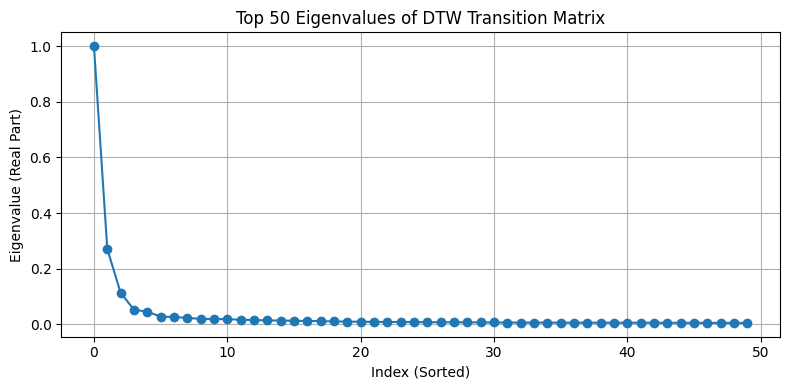

In [ ]:
print("\n--- Task 2: Diffusion Maps ---")

print("Constructing Diffusion Kernel K (DTW based - using median distance)...")

valid_dists_dtw_raw = D_dtw[D_dtw > 1e-9]
if len(valid_dists_dtw_raw) > 0:
    median_dist_dtw = np.median(valid_dists_dtw_raw)
else:
    median_dist_dtw = 1.0

epsilon_dtw = median_dist_dtw
if epsilon_dtw <= 1e-9: epsilon_dtw = 1.0
print(f"Using DTW epsilon (median distance): {epsilon_dtw:.4f}")

K_dtw = np.exp(-D_dtw / epsilon_dtw)
print(f"DTW Kernel matrix K_dtw shape: {K_dtw.shape}")

print("\nComputing Diffusion Map Coordinates (DTW)...")
start_time = time.time()
diffusion_coords_dtw, eigenvalues_dtw, eigenvectors_dtw = run_diffusion_map(K_dtw, N_COMPONENTS_DM, T_DIFFUSION)
print(f"Done in {time.time() - start_time:.2f}s")

plt.figure(figsize=(8, 4))
plt.plot(np.real(eigenvalues_dtw[:50]), 'o-')
plt.title("Top 50 Eigenvalues of DTW Transition Matrix")
plt.xlabel("Index (Sorted)")
plt.ylabel("Eigenvalue (Real Part)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_PATH, 'p1_eigenvalues_dtw.png'))
plt.show()

In [ ]:
print("\n--- Task 3: Clustering ---")
results = {}

print("Applying K-Means on DTW Diffusion Coordinates...")
ari_dm_dtw, sil_dm_dtw = evaluate_clustering(diffusion_coords_dtw, y_windows, N_CLUSTERS)
results['DM (DTW)'] = {'ARI': ari_dm_dtw, 'Silhouette': sil_dm_dtw}
print(f"DM (DTW) - ARI: {ari_dm_dtw:.4f}, Silhouette Score: {sil_dm_dtw:.4f}")


--- Task 3: Clustering ---
Applying K-Means on DTW Diffusion Coordinates...
Clustering completed in 0.25s
DM (DTW) - ARI: 0.3953, Silhouette Score: 0.6368



--- Task 4: Visualization and Interpretation ---
Saved plot to plots/p1_dtw_embedding.png


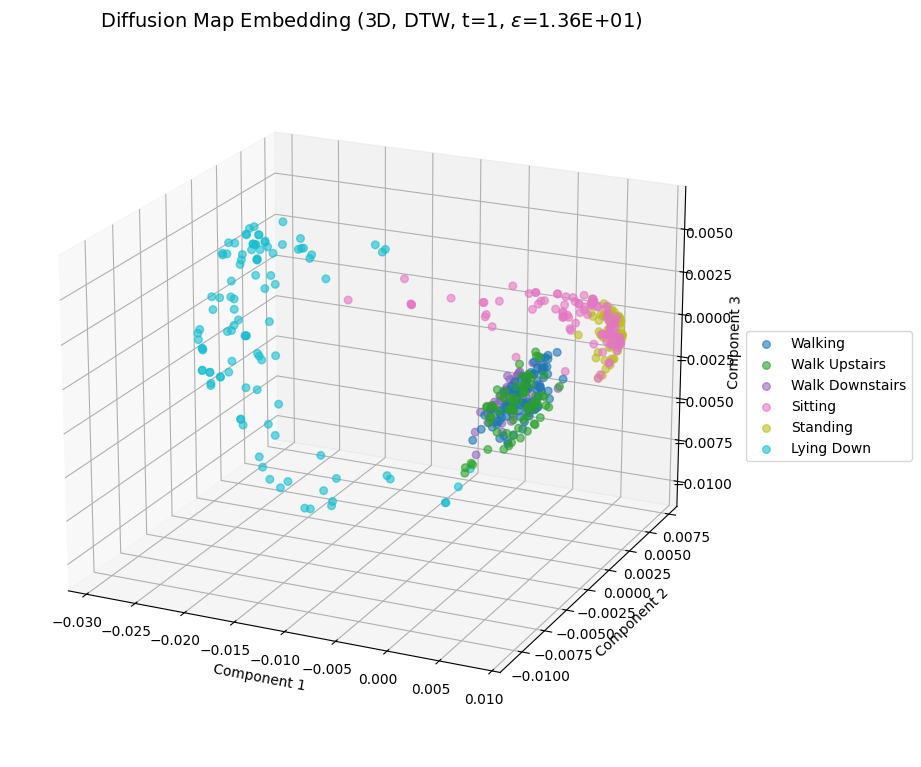


--- Comparing with other embedding spaces ---

Applying K-Means on Scaled Raw Windowed Data...
Clustering completed in 1.70s
Raw Scaled Data - ARI: 0.2509, Silhouette Score: 0.2469

Applying PCA...
PCA done in 0.01s
PCA Explained Variance Ratio (Top 3): [0.23341494 0.04935206 0.04357627]
Saved plot to plots/p1_pca_embedding.png


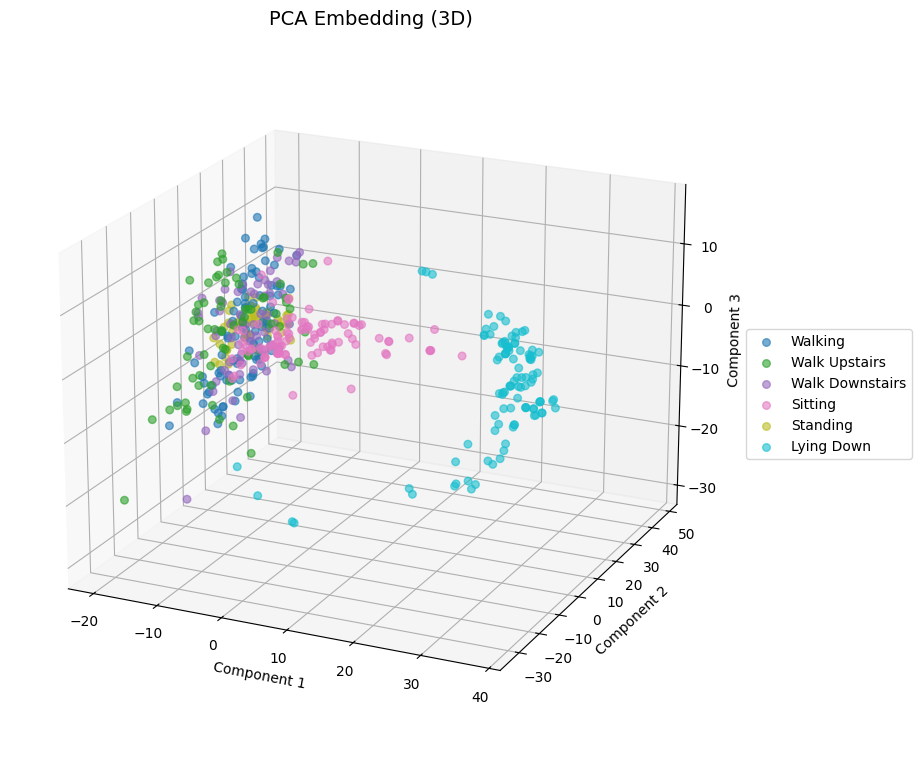


Applying K-Means on PCA Coordinates...
Clustering completed in 0.03s
PCA - ARI: 0.3109, Silhouette Score: 0.3744

Applying t-SNE...
t-SNE done in 0.97s
Saved plot to plots/p1_tsne_embedding.png


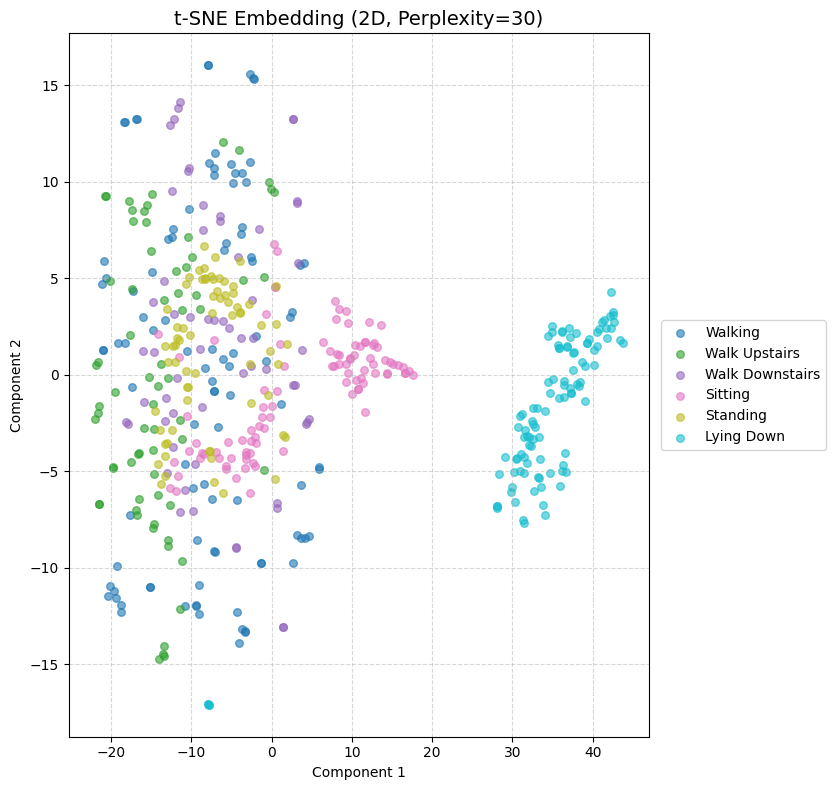


Applying K-Means on t-SNE Coordinates...
Clustering completed in 0.04s
t-SNE - ARI: 0.3494, Silhouette Score: 0.4489

--- Applying Diffusion Maps with Euclidean distance ---
Constructing Diffusion Kernel K (Euclidean based - using median distance)...
Using Euclidean epsilon (median distance): 46.1727
Euclidean Kernel matrix K_euc shape: (500, 500)

Computing Diffusion Map Coordinates (Euclidean)...
Computed 3 diffusion coordinates.
Top 5 eigenvalues (including lambda0): [1.         0.18513661 0.07455946 0.03605482 0.03038568 0.02117817]
Done in 0.41s
Saved plot to plots/p1_euclidean_embedding.png


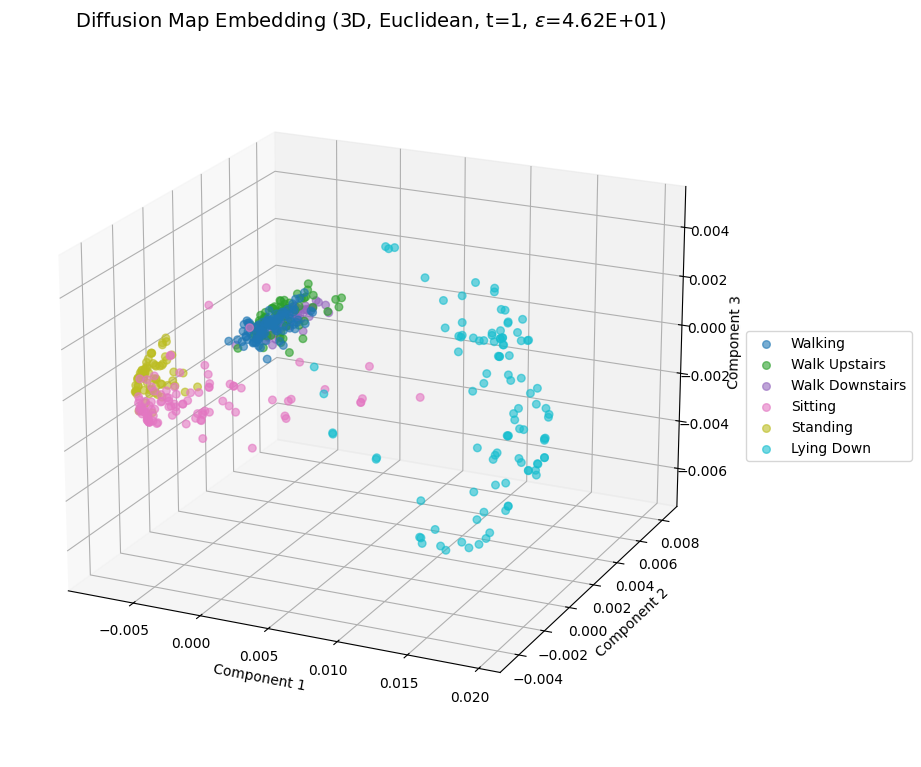


Applying K-Means on Euclidean Diffusion Coordinates...
Clustering completed in 0.03s
DM (Euclidean) - ARI: 0.4183, Silhouette Score: 0.5985

--- Clustering Performance Summary ---
                      ARI  Silhouette
DM (DTW)         0.395266    0.636790
DM (Euclidean)   0.418330    0.598549
PCA              0.310921    0.374379
t-SNE            0.349409    0.448941
Raw Scaled Data  0.250926    0.246896


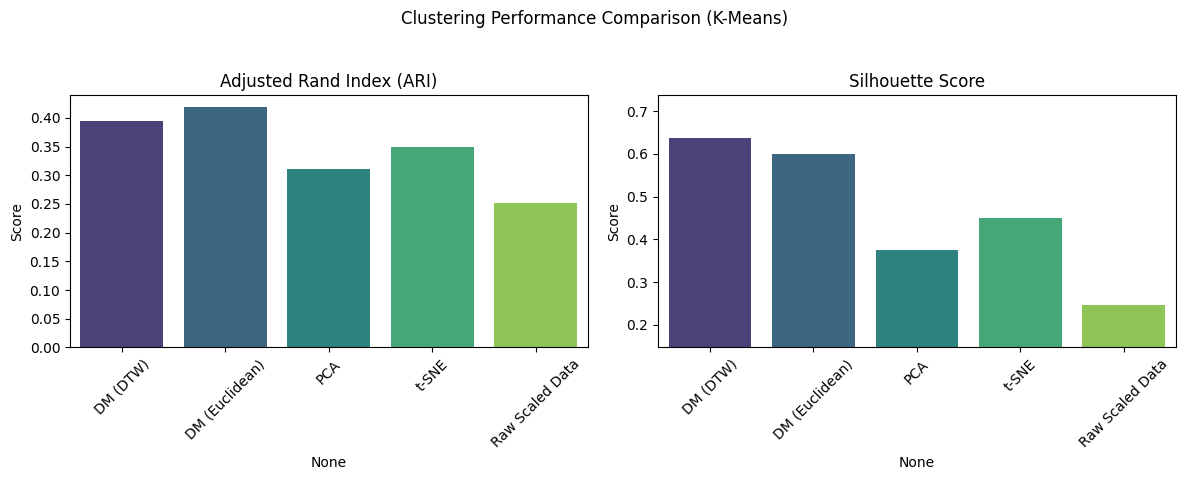


Discussion on Diffusion Maps performance is in README_Problem1.md


In [ ]:
print("\n--- Task 4: Visualization and Interpretation ---")

plot_embedding(diffusion_coords_dtw, y_windows, rf'Diffusion Map Embedding ({N_COMPONENTS_DM}D, DTW, t={T_DIFFUSION}, $\epsilon$={epsilon_dtw:.2E})', f'p1_dtw_embedding.png', n_components=N_COMPONENTS_DM)

print("\n--- Comparing with other embedding spaces ---")

print("\nApplying K-Means on Scaled Raw Windowed Data...")
ari_raw, sil_raw = evaluate_clustering(X_windows_flat_scaled, y_windows, N_CLUSTERS)
results['Raw Scaled Data'] = {'ARI': ari_raw, 'Silhouette': sil_raw}
print(f"Raw Scaled Data - ARI: {ari_raw:.4f}, Silhouette Score: {sil_raw:.4f}")

print("\nApplying PCA...")
start_time = time.time()
pca = PCA(n_components=N_COMPONENTS_PCA, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_windows_flat_scaled)
print(f"PCA done in {time.time() - start_time:.2f}s")
print(f"PCA Explained Variance Ratio (Top {N_COMPONENTS_PCA}): {pca.explained_variance_ratio_}")
plot_embedding(X_pca, y_windows, f'PCA Embedding ({N_COMPONENTS_PCA}D)', 'p1_pca_embedding.png', n_components=N_COMPONENTS_PCA)

print("\nApplying K-Means on PCA Coordinates...")
ari_pca, sil_pca = evaluate_clustering(X_pca, y_windows, N_CLUSTERS)
results['PCA'] = {'ARI': ari_pca, 'Silhouette': sil_pca}
print(f"PCA - ARI: {ari_pca:.4f}, Silhouette Score: {sil_pca:.4f}")

print("\nApplying t-SNE...")
start_time = time.time()
tsne = TSNE(n_components=N_COMPONENTS_TSNE, perplexity=TSNE_PERPLEXITY, random_state=RANDOM_STATE, n_jobs=-1)
X_tsne = tsne.fit_transform(X_windows_flat_scaled)
print(f"t-SNE done in {time.time() - start_time:.2f}s")
plot_embedding(X_tsne, y_windows, f't-SNE Embedding ({N_COMPONENTS_TSNE}D, Perplexity={TSNE_PERPLEXITY})', 'p1_tsne_embedding.png', n_components=N_COMPONENTS_TSNE)

print("\nApplying K-Means on t-SNE Coordinates...")
ari_tsne, sil_tsne = evaluate_clustering(X_tsne, y_windows, N_CLUSTERS)
results['t-SNE'] = {'ARI': ari_tsne, 'Silhouette': sil_tsne}
print(f"t-SNE - ARI: {ari_tsne:.4f}, Silhouette Score: {sil_tsne:.4f}")

print("\n--- Applying Diffusion Maps with Euclidean distance ---")
print("Constructing Diffusion Kernel K (Euclidean based - using median distance)...")

valid_dists_euc_raw = D_euc[D_euc > 1e-9]
if len(valid_dists_euc_raw) > 0:
    median_dist_euc = np.median(valid_dists_euc_raw)
else:
    median_dist_euc = 1.0
epsilon_euc = median_dist_euc
if epsilon_euc <= 1e-9: epsilon_euc = 1.0
print(f"Using Euclidean epsilon (median distance): {epsilon_euc:.4f}")

K_euc = np.exp(-D_euc / epsilon_euc)
print(f"Euclidean Kernel matrix K_euc shape: {K_euc.shape}")

print("\nComputing Diffusion Map Coordinates (Euclidean)...")
start_time = time.time()
diffusion_coords_euc, eigenvalues_euc, eigenvectors_euc = run_diffusion_map(K_euc, N_COMPONENTS_DM, T_DIFFUSION)
print(f"Done in {time.time() - start_time:.2f}s")

plot_embedding(diffusion_coords_euc, y_windows, rf'Diffusion Map Embedding ({N_COMPONENTS_DM}D, Euclidean, t={T_DIFFUSION}, $\epsilon$={epsilon_euc:.2E})', 'p1_euclidean_embedding.png', n_components=N_COMPONENTS_DM)

print("\nApplying K-Means on Euclidean Diffusion Coordinates...")
ari_dm_euc, sil_dm_euc = evaluate_clustering(diffusion_coords_euc, y_windows, N_CLUSTERS)
results['DM (Euclidean)'] = {'ARI': ari_dm_euc, 'Silhouette': sil_dm_euc}
print(f"DM (Euclidean) - ARI: {ari_dm_euc:.4f}, Silhouette Score: {sil_dm_euc:.4f}")


print("\n--- Clustering Performance Summary ---")
df_results = pd.DataFrame(results).T
df_results = df_results.reindex(['DM (DTW)', 'DM (Euclidean)', 'PCA', 't-SNE', 'Raw Scaled Data'])

print(df_results)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=df_results.index, y='ARI', data=df_results, ax=axes[0], palette='viridis')
axes[0].set_title('Adjusted Rand Index (ARI)')
axes[0].set_ylabel('Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(bottom=0)

sns.barplot(x=df_results.index, y='Silhouette', data=df_results, ax=axes[1], palette='viridis')
axes[1].set_title('Silhouette Score')
axes[1].set_ylabel('Score')
axes[1].tick_params(axis='x', rotation=45)
sil_min = df_results['Silhouette'].min()
sil_max = df_results['Silhouette'].max()
axes[1].set_ylim(bottom=max(-1, sil_min - 0.1), top=min(1, sil_max + 0.1))

plt.suptitle('Clustering Performance Comparison (K-Means)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(PLOT_PATH, 'p1_clustering_comparison.png'))
plt.show()

print("\nDiscussion on Diffusion Maps performance is in README_Problem1.md")


--- Task 5: Explorative ---

Exploring Multiscale Diffusion Maps by varying diffusion time 't'...

--- Computing DM (DTW) with t = 1 ---
Saved plot to plots/p1_dtw_embedding_t1.png


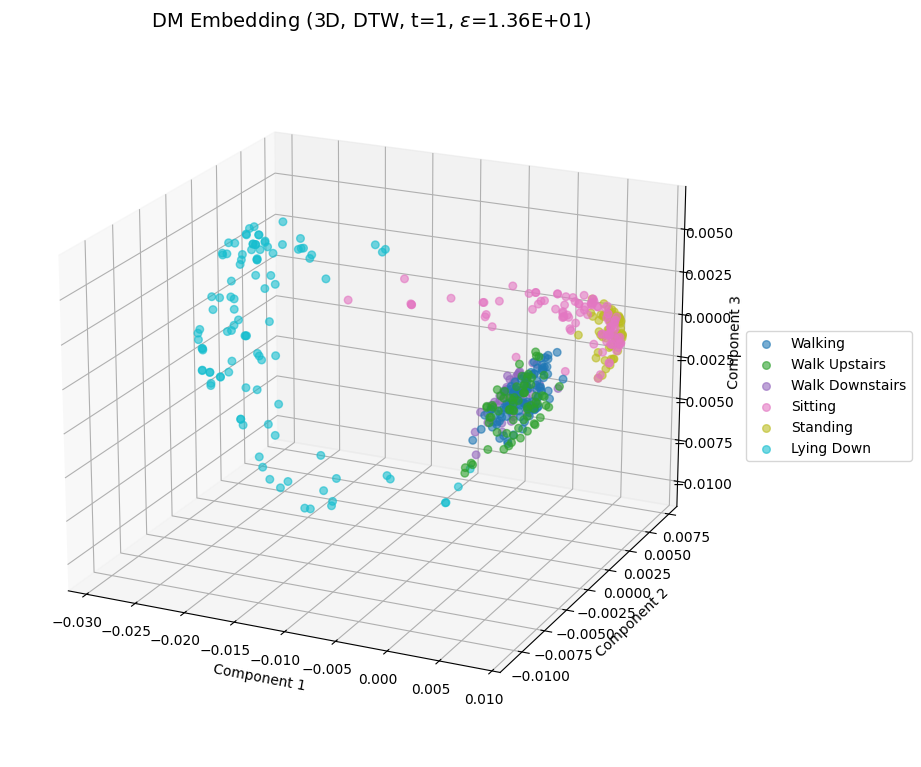

Applying K-Means on DM (DTW, t=1)...
Clustering completed in 0.04s
DM (DTW, t=1) - ARI: 0.3953, Silhouette Score: 0.6368

--- Computing DM (DTW) with t = 5 ---
Saved plot to plots/p1_dtw_embedding_t5.png


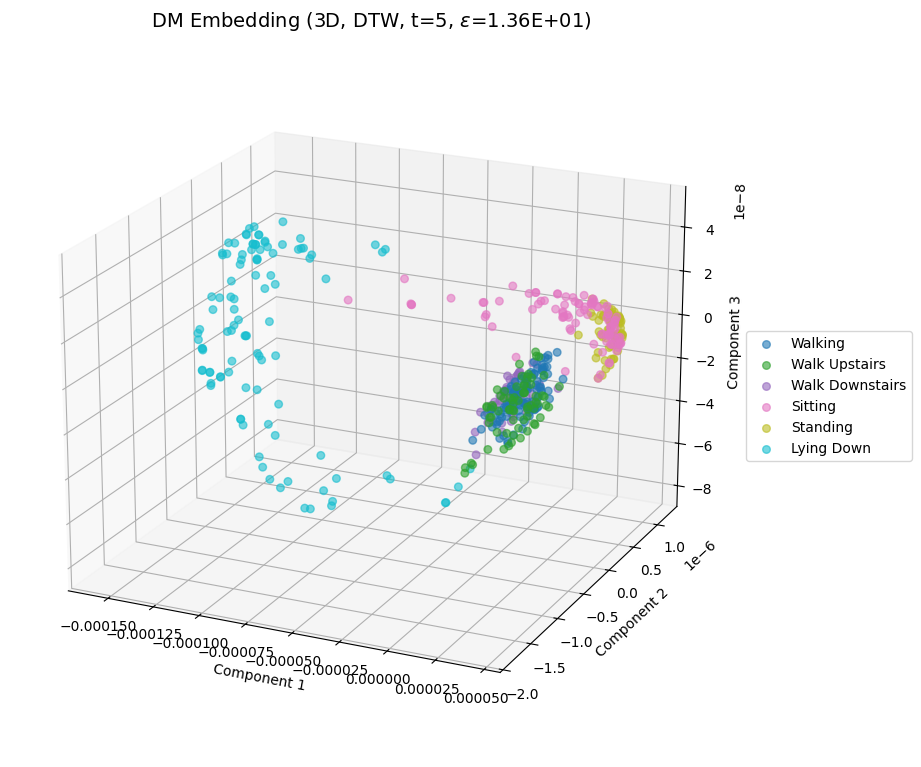

Applying K-Means on DM (DTW, t=5)...
Clustering completed in 0.03s
DM (DTW, t=5) - ARI: 0.2282, Silhouette Score: 0.5843

--- Computing DM (DTW) with t = 10 ---
Saved plot to plots/p1_dtw_embedding_t10.png


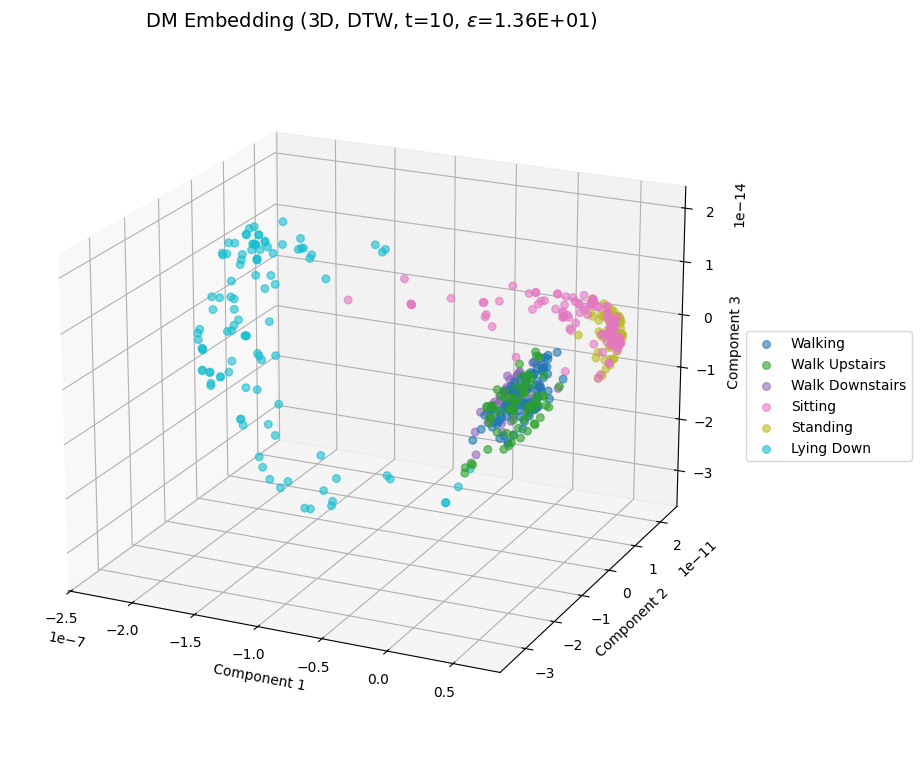

Applying K-Means on DM (DTW, t=10)...
Clustering completed in 0.03s
DM (DTW, t=10) - ARI: 0.2282, Silhouette Score: 0.6023

Multiscale Results Summary:
                     ARI  Silhouette
DM (DTW, t=1)   0.395266    0.636790
DM (DTW, t=5)   0.228213    0.584256
DM (DTW, t=10)  0.228213    0.602345

--- Applying Spectral Clustering ---
Applying Spectral Clustering on DTW Kernel K_dtw...
Spectral clustering done in 0.24s
Spectral Clustering (on K_dtw) - ARI: 0.4391, Silhouette Score: 0.3727

--- Problem 1 Finished ---
Total execution time: 0.36 minutes


In [ ]:
print("\n--- Task 5: Explorative ---")

print("\nExploring Multiscale Diffusion Maps by varying diffusion time 't'...")
t_values = [1, 5, 10]
results_multiscale = {}

for t_val in t_values:
    print(f"\n--- Computing DM (DTW) with t = {t_val} ---")
    lambdas_t_val = eigenvalues_dtw[1:N_COMPONENTS_DM+1]**t_val
    vecs_t_val = eigenvectors_dtw[:, 1:N_COMPONENTS_DM+1]
    diffusion_coords_t_val = vecs_t_val * lambdas_t_val

    plot_embedding(diffusion_coords_t_val, y_windows,
               rf'DM Embedding ({N_COMPONENTS_DM}D, DTW, t={t_val}, $\epsilon$={epsilon_dtw:.2E})',
               f'p1_dtw_embedding_t{t_val}.png', n_components=N_COMPONENTS_DM)

    print(f"Applying K-Means on DM (DTW, t={t_val})...")
    ari_t, sil_t = evaluate_clustering(diffusion_coords_t_val, y_windows, N_CLUSTERS)
    results_multiscale[f'DM (DTW, t={t_val})'] = {'ARI': ari_t, 'Silhouette': sil_t}
    print(f"DM (DTW, t={t_val}) - ARI: {ari_t:.4f}, Silhouette Score: {sil_t:.4f}")

print("\nMultiscale Results Summary:")
df_multiscale = pd.DataFrame(results_multiscale).T
print(df_multiscale)

print("\n--- Applying Spectral Clustering ---")
print("Applying Spectral Clustering on DTW Kernel K_dtw...")
start_time = time.time()
spectral = SpectralClustering(n_clusters=N_CLUSTERS,
                              affinity='precomputed',
                              assign_labels='kmeans',
                              random_state=RANDOM_STATE)
spectral_labels = spectral.fit_predict(K_dtw)
print(f"Spectral clustering done in {time.time() - start_time:.2f}s")

ari_spectral = adjusted_rand_score(y_windows, spectral_labels)

try:
    silhouette_spectral = silhouette_score(diffusion_coords_dtw, spectral_labels)
except ValueError:
    silhouette_spectral = -1

results['Spectral (on K_dtw)'] = {'ARI': ari_spectral, 'Silhouette': silhouette_spectral}
print(f"Spectral Clustering (on K_dtw) - ARI: {ari_spectral:.4f}, Silhouette Score: {silhouette_spectral:.4f}")


end_total_time = time.time()
print(f"\n--- Problem 1 Finished ---")
print(f"Total execution time: {(end_total_time - start_total_time)/60:.2f} minutes")